In [43]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

nb_epoch = 50
batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ridiculously_small'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        patch_out = patch_in[5: 53, 5: 53]
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (61, 56, 56)   out (61, 48, 48)
in (32, 56, 56)   out (32, 48, 48)


In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(61, 56, 56, 1) (61, 48, 48, 1)
(32, 56, 56, 1) (32, 48, 48, 1)


In [7]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

In [10]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])], trainable=False)(flattened)

# INSERT CODE HERE
x = Dense(1152, activation="relu")(briefed)
# x = Dense(2304, activation="elu")(x)
x = Reshape((12, 12, 8))(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)


# x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)




brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer='adadelta', loss="binary_crossentropy")
brief_ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1180

In [41]:
model_version = '0.0.0.1_decoder_dense1152_conv833_up_conv833_up_conv133__relu_last_sigmoid_bce_trainlong'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=10000,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0]#,
#                 callbacks=[checkpointer]
                )

brief_ae.save(base_dir + '/brief_ae' + model_version + '.h5')


Epoch 1/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6082 - val_loss: 0.6925
Epoch 2/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6078 - val_loss: 0.7068
Epoch 3/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6080 - val_loss: 0.6932
Epoch 4/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6073 - val_loss: 0.7056
Epoch 5/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6072 - val_loss: 0.6912
Epoch 6/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6067 - val_loss: 0.7014
Epoch 7/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6068 - val_loss: 0.6877
Epoch 8/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6063 - val_loss: 0.7023
Epoch 9/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6061 - val_loss: 0.6890
Epoch 10/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.6056 - val_lo

61/61 [==============================] - 2s 36ms/step - loss: 0.5896 - val_loss: 0.6876
Epoch 82/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5912 - val_loss: 0.6952
Epoch 83/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5900 - val_loss: 0.7156
Epoch 84/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5899 - val_loss: 0.6951
Epoch 85/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5898 - val_loss: 0.7008
Epoch 86/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5883 - val_loss: 0.6927
Epoch 87/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5889 - val_loss: 0.7075
Epoch 88/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5890 - val_loss: 0.6904
Epoch 89/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5889 - val_loss: 0.7150
Epoch 90/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5896 - val_loss: 0

Epoch 161/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5782 - val_loss: 0.6974
Epoch 162/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5785 - val_loss: 0.7020
Epoch 163/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5782 - val_loss: 0.7117
Epoch 164/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5787 - val_loss: 0.7013
Epoch 165/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5781 - val_loss: 0.7014
Epoch 166/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5782 - val_loss: 0.6992
Epoch 167/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5784 - val_loss: 0.7142
Epoch 168/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5779 - val_loss: 0.7157
Epoch 169/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5793 - val_loss: 0.7047
Epoch 170/1000
61/61 [==============================] - 2s 36ms/step - lo

61/61 [==============================] - 2s 36ms/step - loss: 0.5743 - val_loss: 0.7071
Epoch 241/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5740 - val_loss: 0.7146
Epoch 242/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5756 - val_loss: 0.6954
Epoch 243/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5748 - val_loss: 0.6970
Epoch 244/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5745 - val_loss: 0.7132
Epoch 245/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5722 - val_loss: 0.7043
Epoch 246/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5767 - val_loss: 0.6949
Epoch 247/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5740 - val_loss: 0.7218
Epoch 248/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5748 - val_loss: 0.6988
Epoch 249/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5742 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5723 - val_loss: 0.6991
Epoch 320/1000
61/61 [==============================] - 2s 37ms/step - loss: 0.5717 - val_loss: 0.7231
Epoch 321/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5723 - val_loss: 0.6966
Epoch 322/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5709 - val_loss: 0.7084
Epoch 323/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5714 - val_loss: 0.6958
Epoch 324/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5716 - val_loss: 0.7042
Epoch 325/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5718 - val_loss: 0.7282
Epoch 326/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5711 - val_loss: 0.6968
Epoch 327/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5714 - val_loss: 0.7348
Epoch 328/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5717 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5711 - val_loss: 0.7015
Epoch 399/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5695 - val_loss: 0.7144
Epoch 400/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5697 - val_loss: 0.7214
Epoch 401/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5699 - val_loss: 0.6991
Epoch 402/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5698 - val_loss: 0.7240
Epoch 403/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5695 - val_loss: 0.7004
Epoch 404/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5692 - val_loss: 0.7266
Epoch 405/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5700 - val_loss: 0.6988
Epoch 406/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5694 - val_loss: 0.7272
Epoch 407/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5701 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5685 - val_loss: 0.7046
Epoch 478/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5684 - val_loss: 0.7198
Epoch 479/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5684 - val_loss: 0.7158
Epoch 480/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5681 - val_loss: 0.7264
Epoch 481/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5684 - val_loss: 0.7020
Epoch 482/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5688 - val_loss: 0.7268
Epoch 483/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5674 - val_loss: 0.7236
Epoch 484/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5680 - val_loss: 0.7053
Epoch 485/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5675 - val_loss: 0.7030
Epoch 486/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5686 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5673 - val_loss: 0.7088
Epoch 557/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5658 - val_loss: 0.7049
Epoch 558/1000
61/61 [==============================] - 2s 37ms/step - loss: 0.5667 - val_loss: 0.7247
Epoch 559/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5660 - val_loss: 0.7142
Epoch 560/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5669 - val_loss: 0.7064
Epoch 561/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5664 - val_loss: 0.7141
Epoch 562/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5669 - val_loss: 0.7080
Epoch 563/1000
61/61 [==============================] - 2s 37ms/step - loss: 0.5667 - val_loss: 0.7142
Epoch 564/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5665 - val_loss: 0.7131
Epoch 565/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5670 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5657 - val_loss: 0.7411
Epoch 636/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5639 - val_loss: 0.7179
Epoch 637/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5659 - val_loss: 0.7106
Epoch 638/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5652 - val_loss: 0.7231
Epoch 639/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5658 - val_loss: 0.7098
Epoch 640/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5653 - val_loss: 0.7406
Epoch 641/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5652 - val_loss: 0.7056
Epoch 642/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5658 - val_loss: 0.7280
Epoch 643/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5638 - val_loss: 0.7270
Epoch 644/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5656 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5652 - val_loss: 0.7045
Epoch 715/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5642 - val_loss: 0.7331
Epoch 716/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5643 - val_loss: 0.7119
Epoch 717/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5646 - val_loss: 0.7091
Epoch 718/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5643 - val_loss: 0.7089
Epoch 719/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5642 - val_loss: 0.7334
Epoch 720/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5638 - val_loss: 0.7352
Epoch 721/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5647 - val_loss: 0.7107
Epoch 722/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5642 - val_loss: 0.7264
Epoch 723/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5635 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5632 - val_loss: 0.7120
Epoch 794/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5642 - val_loss: 0.7364
Epoch 795/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5630 - val_loss: 0.7322
Epoch 796/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5629 - val_loss: 0.7210
Epoch 797/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5634 - val_loss: 0.7084
Epoch 798/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5631 - val_loss: 0.7107
Epoch 799/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5635 - val_loss: 0.7230
Epoch 800/1000
61/61 [==============================] - 2s 37ms/step - loss: 0.5627 - val_loss: 0.7071
Epoch 801/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5632 - val_loss: 0.7289
Epoch 802/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5636 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5628 - val_loss: 0.7081
Epoch 873/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5615 - val_loss: 0.7182
Epoch 874/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5623 - val_loss: 0.7312
Epoch 875/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5629 - val_loss: 0.7108
Epoch 876/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5619 - val_loss: 0.7191
Epoch 877/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5632 - val_loss: 0.7287
Epoch 878/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5619 - val_loss: 0.7117
Epoch 879/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5626 - val_loss: 0.7144
Epoch 880/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5627 - val_loss: 0.7265
Epoch 881/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5624 - va

61/61 [==============================] - 2s 36ms/step - loss: 0.5606 - val_loss: 0.7315
Epoch 952/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5627 - val_loss: 0.7121
Epoch 953/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5606 - val_loss: 0.7443
Epoch 954/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5625 - val_loss: 0.7336
Epoch 955/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5620 - val_loss: 0.7170
Epoch 956/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5617 - val_loss: 0.7295
Epoch 957/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5622 - val_loss: 0.7168
Epoch 958/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5610 - val_loss: 0.7151
Epoch 959/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5631 - val_loss: 0.7317
Epoch 960/1000
61/61 [==============================] - 2s 36ms/step - loss: 0.5621 - va

predictions: 


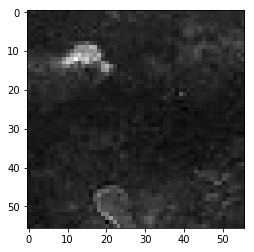

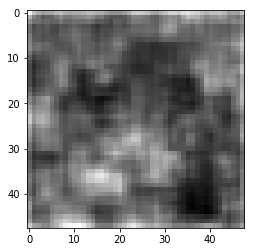

next


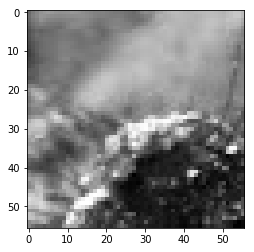

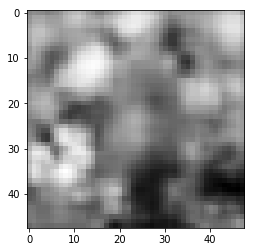

next


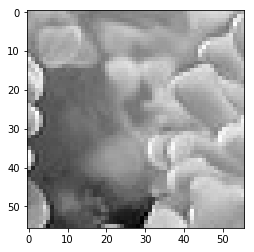

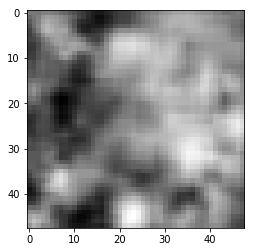

next


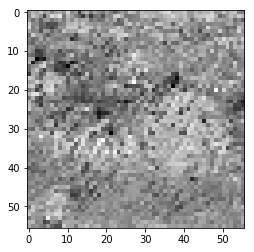

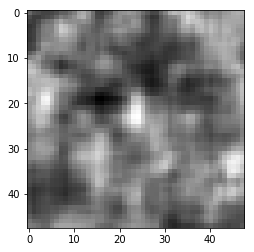

next


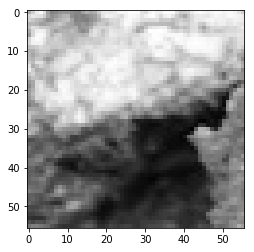

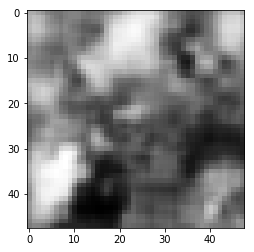

next


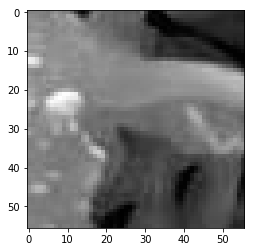

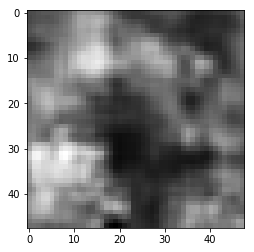

next


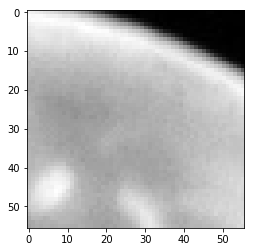

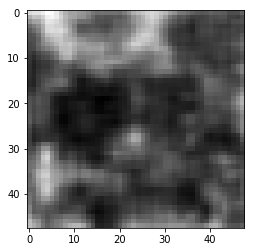

next


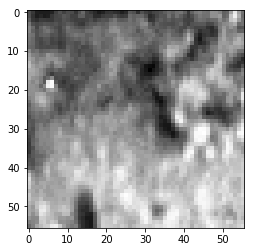

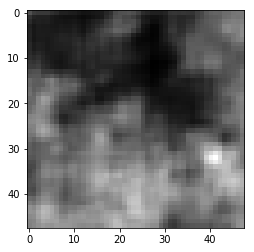

next


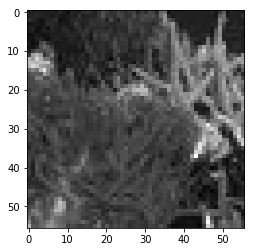

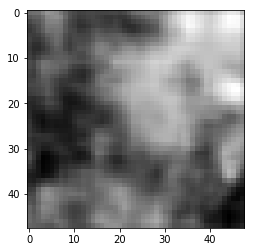

next


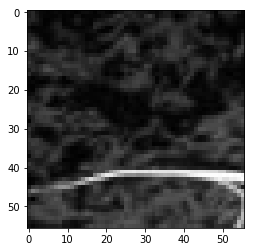

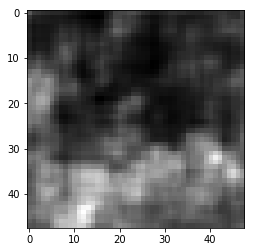

next


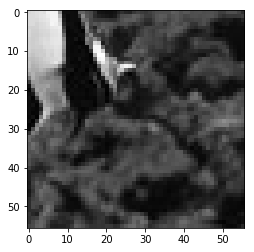

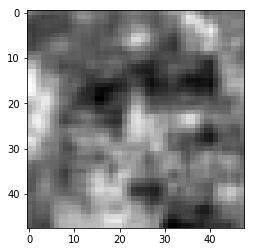

next


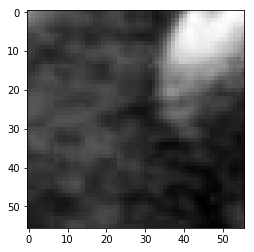

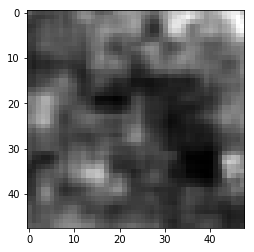

next


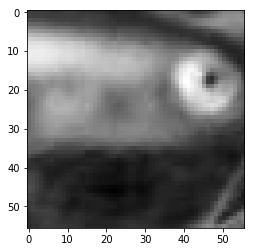

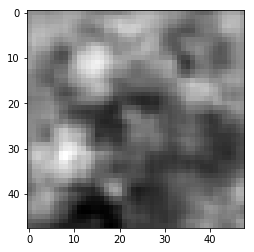

next


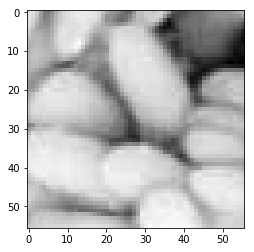

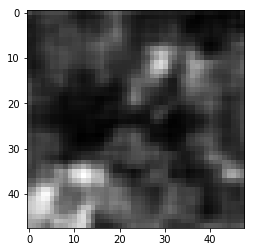

next


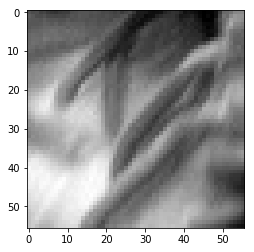

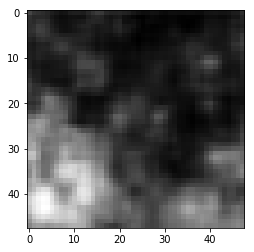

next


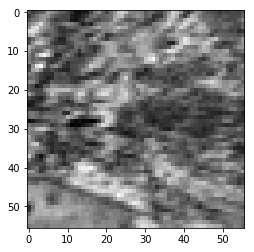

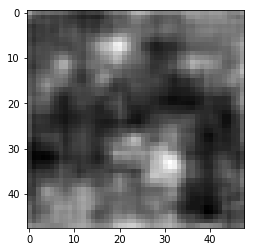

next


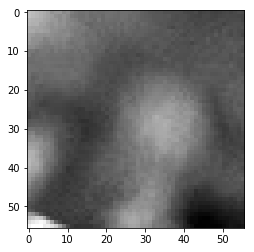

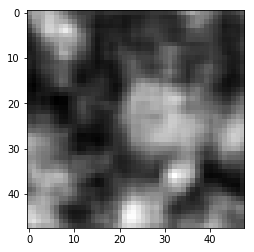

next


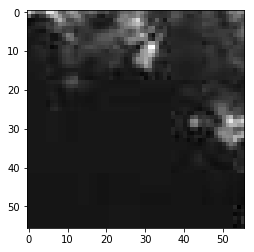

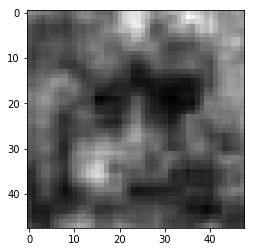

next


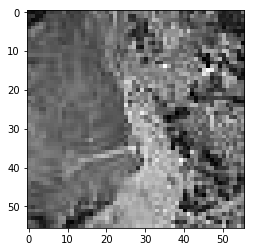

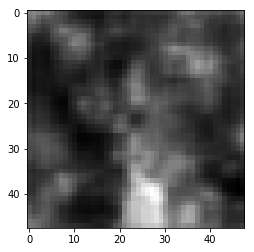

next


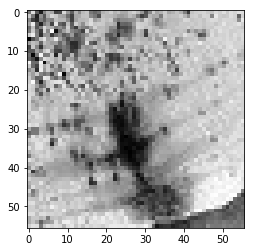

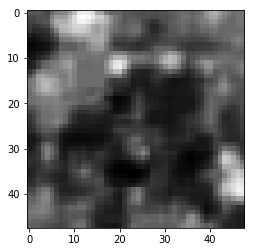

next


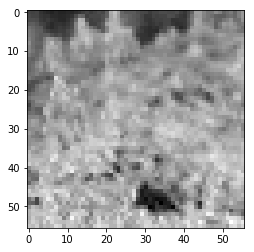

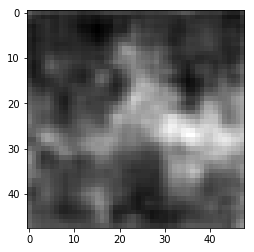

next


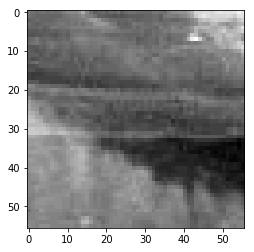

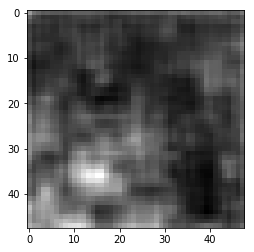

next


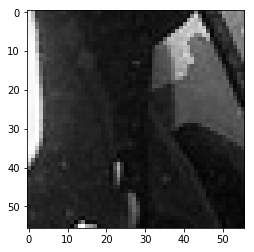

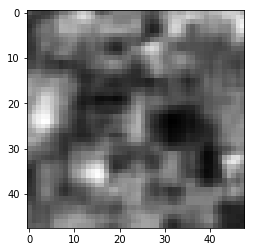

next


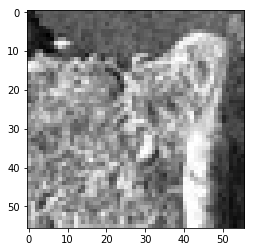

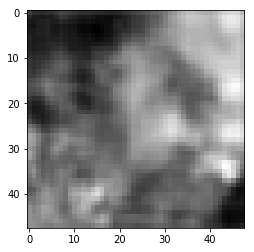

next


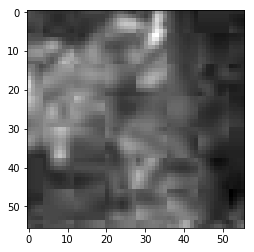

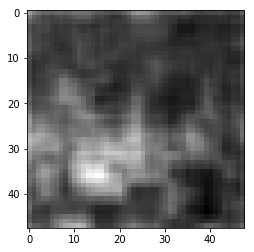

next


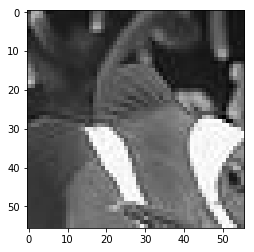

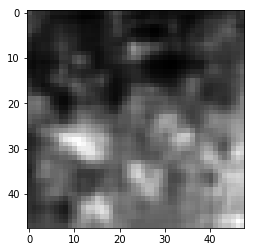

next


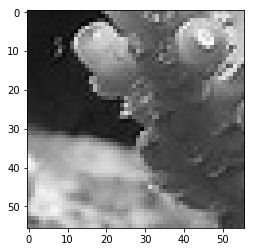

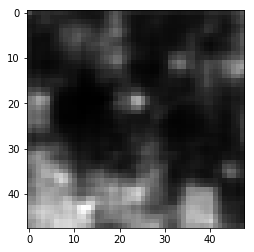

next


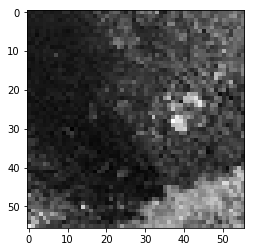

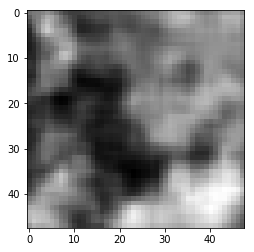

next


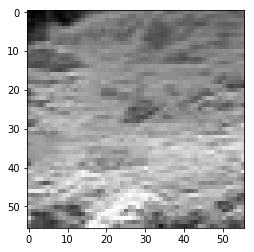

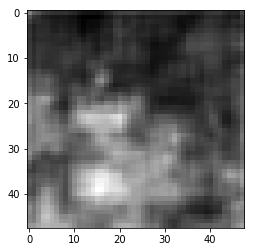

next


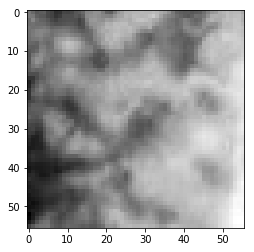

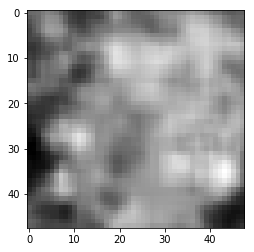

next


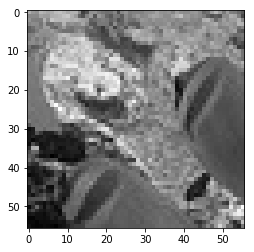

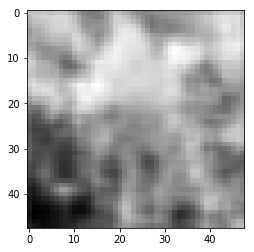

next


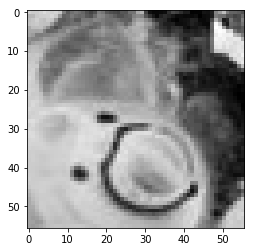

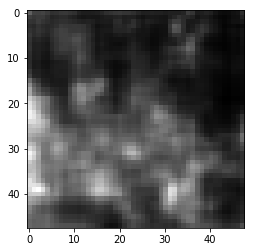

next


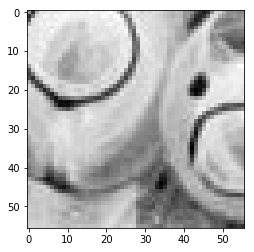

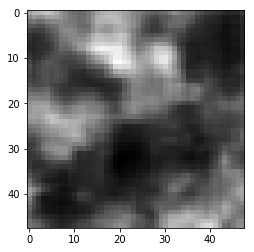

next


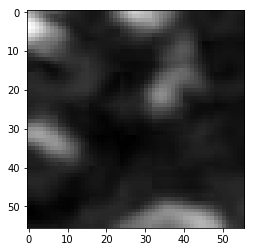

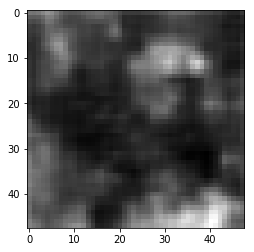

next


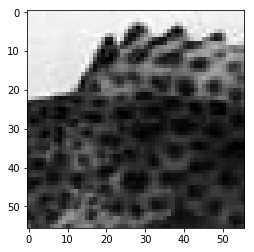

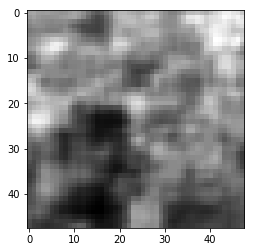

next


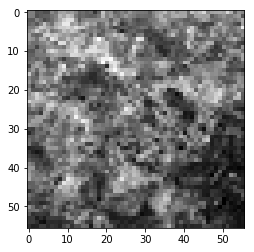

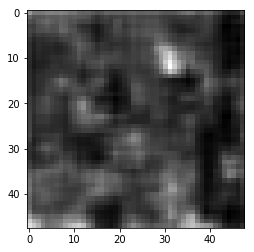

next


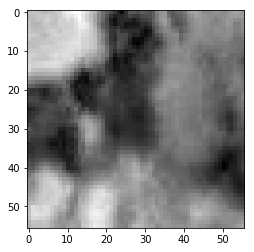

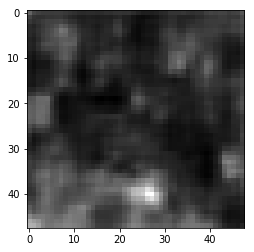

next


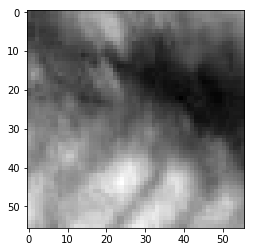

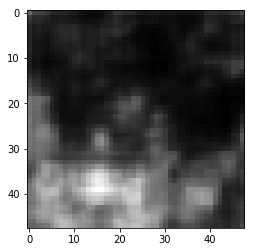

next


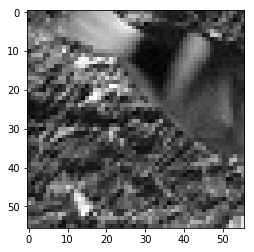

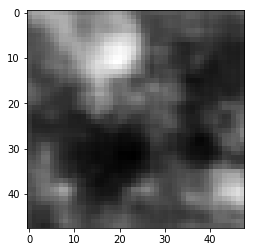

next


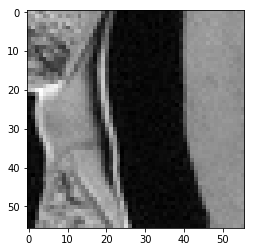

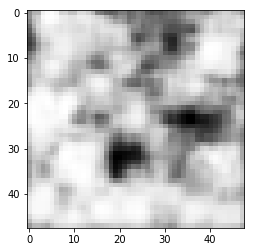

next


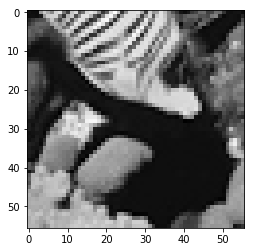

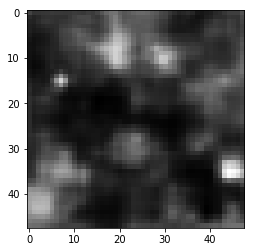

next


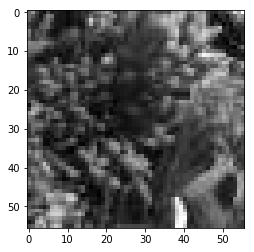

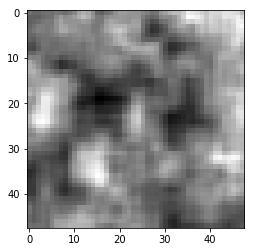

next


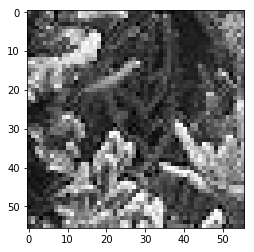

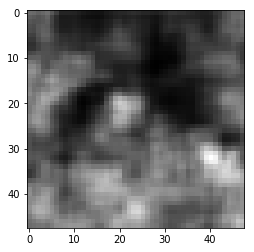

next


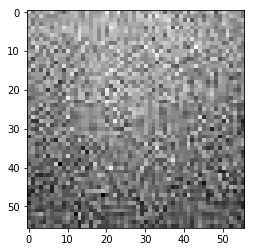

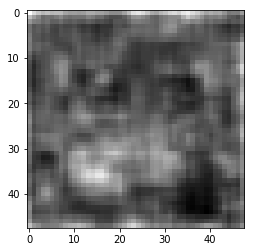

next


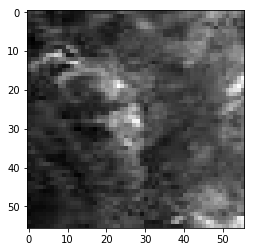

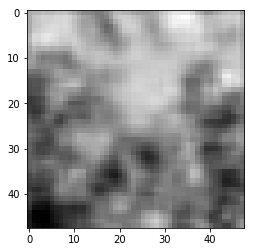

next


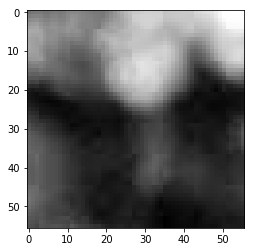

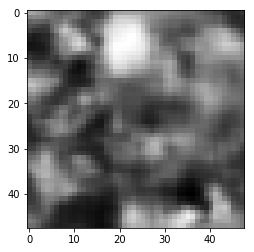

next


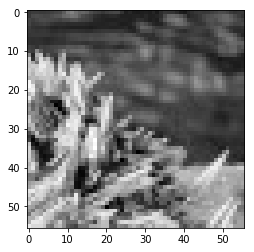

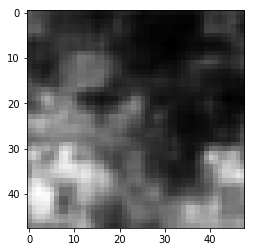

next


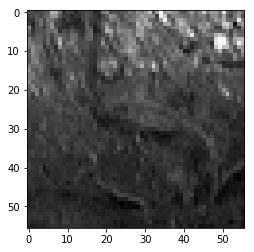

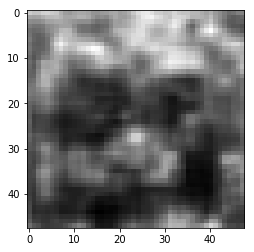

next


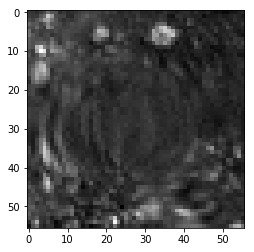

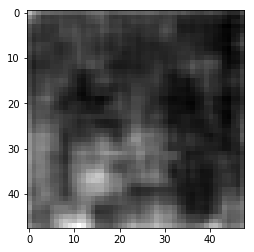

next


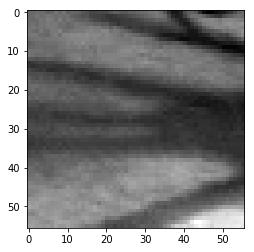

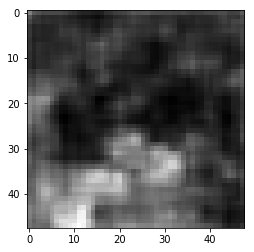

next


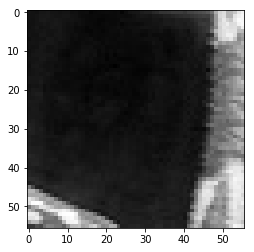

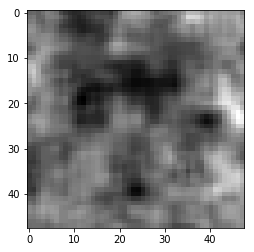

next


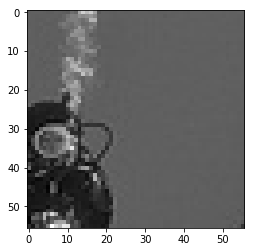

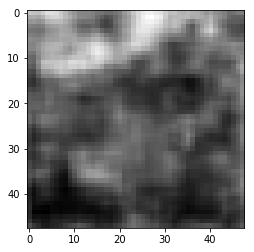

next


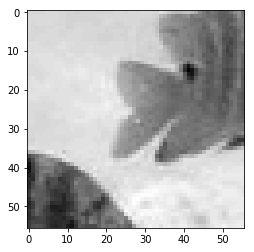

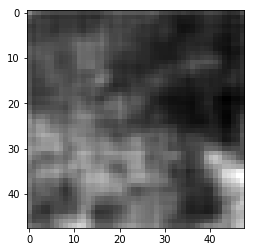

next


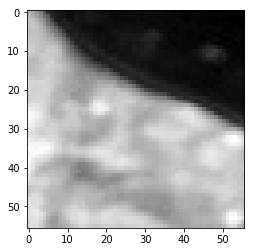

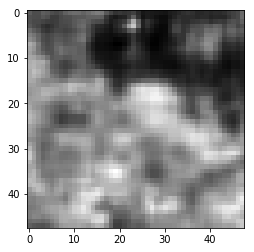

next


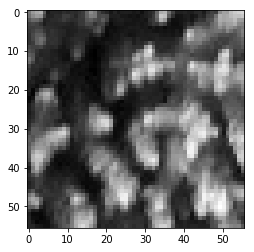

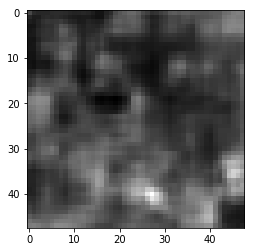

next


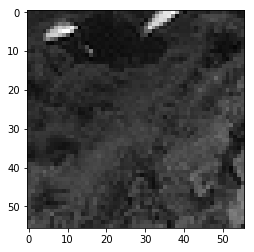

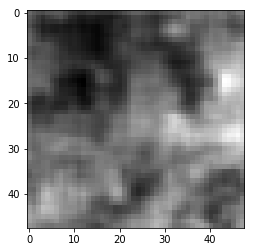

next


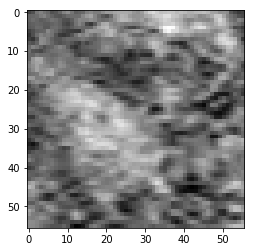

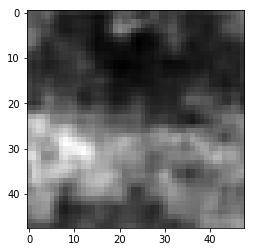

next


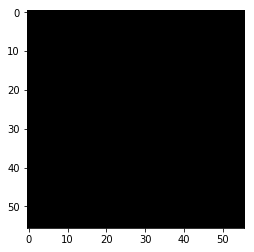

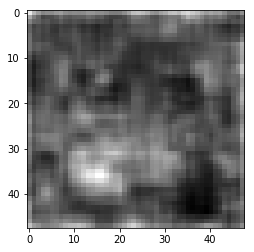

next


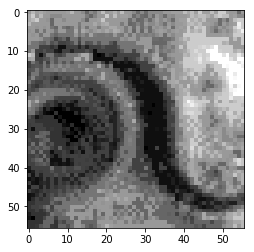

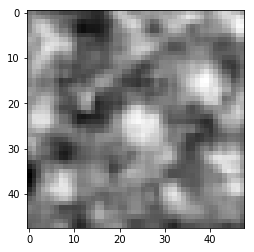

next


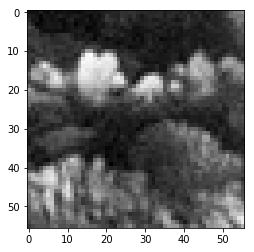

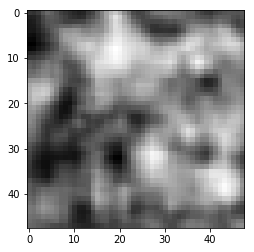

next


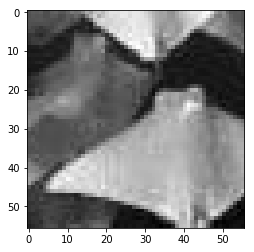

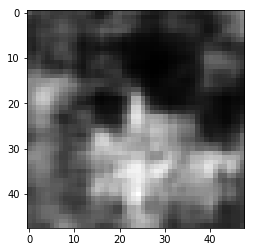

next


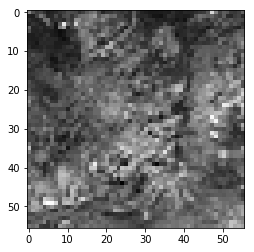

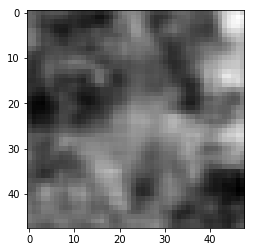

next


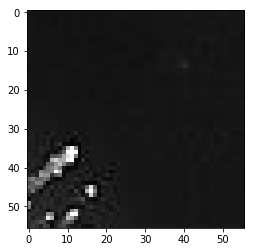

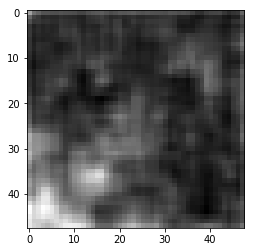

next


In [42]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    pred_1 = predictions[i].reshape((brief_patch_size, brief_patch_size))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    print("next")